<a href="https://colab.research.google.com/github/tkhan3/machinelearning/blob/master/Clickstream_Analytics_for_Consumer_Electronics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Before we start the lab let us prepare the environment first. Execute the next cell and it will print out a lot of gibberish ;-) which you can ignore*

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xvf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
#####################################################################

--2020-08-31 07:54:01--  https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232530699 (222M) [application/x-gzip]
Saving to: ‘spark-2.4.5-bin-hadoop2.7.tgz’

spark-2.4.5-bin-had 100%[===================>] 221.76M  24.8MB/s    in 9.6s    

2020-08-31 07:54:11 (23.1 MB/s) - ‘spark-2.4.5-bin-hadoop2.7.tgz’ saved [232530699/232530699]

spark-2.4.5-bin-hadoop2.7/
spark-2.4.5-bin-hadoop2.7/licenses/
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-jtransforms.html
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-zstd.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-zstd-jni.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-xmlenc.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-vis.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-spire.txt
spark-2.4.5-b

*The next block of code should run without failing*

*Expected output : [1,2,3,4,5]*

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
data = [1, 2, 3, 4, 5]
distData = spark.sparkContext.parallelize(data)
distData.collect()

[1, 2, 3, 4, 5]

# **Clickstream Analytics for Consumer Electronics**

---



## **Electronics for You**

Electronics for You (EFY) is a major retailer selling consumer electronics. Although they have both stores and online channels 90% of their revenue is from stores. They however significant online traffic and they would like to convert more in the online channel.

Since consumer electronics is a heavily discounted industry segment, store sales give them lesser margins than online sales. Competitive pricing forces them to be able to price-math offline and online stores of both themselves and their competitors.







The consumer eletronics industry is very unique among retail segments. For many consumer electronics products especially the high purchase ones purchase cycles are very long often as long as 7-10 years or more. On the other hand technologies in these products change rapidly. For example, it is only in 2017 that the world's first commercial shipment of inkjet printed OLED panels were introduced.

[Ref: Wikipedia](https://en.wikipedia.org/wiki/OLED)



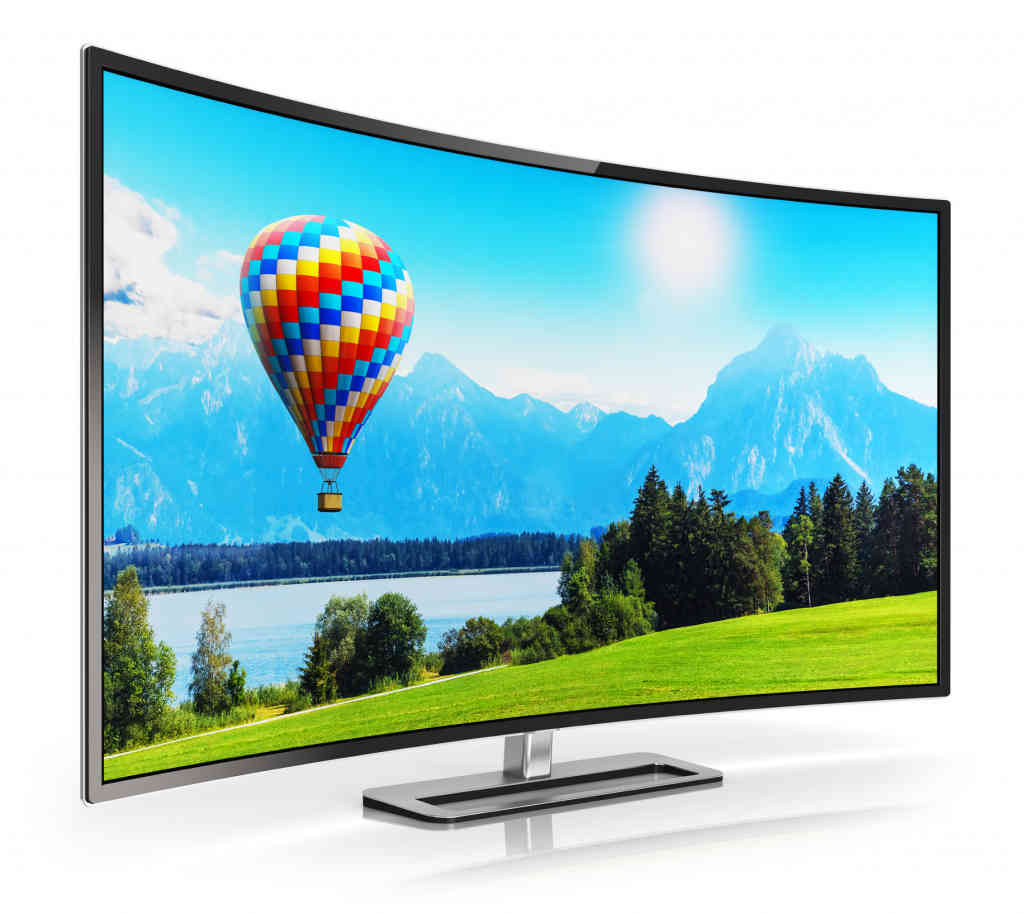

Traditional recommendation algorithms do not work because consumer history is not saved for such long periods (often due to mandatory data archival regulations) and also even if present they give little insight into people's purchase behaviour for long periods of time. Therefore for many categories in consumer electronics purchase history based analytics is of limited value.

**It is therefore preferable to use clickstream analytics based analytics.**

Clickstream analytics provides rich insight into various aspects of consumer behaviour if used properly and insights derived correctly.Some very simple analytics can be used to understand purchase patterns over time. Let's look at some examples before dive deep into clickstream analytics.

We would look to plot and analyze similar details with our data.

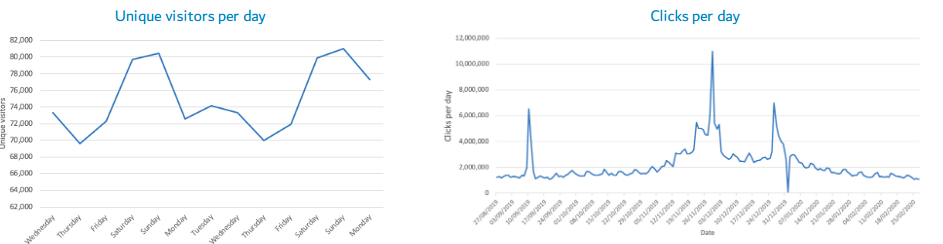

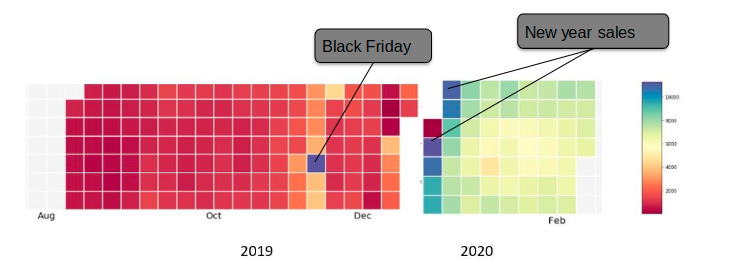

# **CLICKSTREAM DATA**

Clickstream data can be huge. For example, EFY's clickstreamd data for two categories - TV and Washing Machine on one day was a whopping 1713094 rows of data and was 360 MB when exported in a CSV file.

Electronics for You has 16 major categories. If we assume each of the categories are similar then a year's worth of data would be 1 TB of data with close to 5 Billion rows of data.

This is **BIG DATA** - how do we analyze and model on such large volumes of data ?

**Understanding Clickstream Data**

Clickstream systems record an event per click - it is no surprise that the data often becomes so large. However most click stream systems use a concept of "visitor id" which identifies a customer based on their login (if they are logged in) or on cookies if enabled / permission granted. 

Note that this is NOT an infallible system. If multiple people in the same home share a desktop computer for example, clickstream analytics will not be able to distinguish them. Also cookies are deleted often by users for various reasons. Some retailers provide omnichannel experience by allowing cookies across devices - if enabled and there are common logins. Despite these limitations clickstream analytics is useful, insightful and often invaluable.



In [ ]:
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



Follow the instructions below to read the files into your Google Colab

**< INSTRUCTIONS TO BE ADDED >**



In [ ]:
import os
os.listdir('./gdrive/My Drive/IIMU_course_Lab')

['PRODUCT_CLASSIFICATION.csv',
 'CAM.csv',
 'TV.csv',
 'click_data.txt',
 'dataSimulation.py',
 'click_data_1000_users.txt',
 'click_data1.txt']

In [ ]:
click_data=spark.read.options(header="true",inferschema = "true").csv('./gdrive/My Drive/IIMU_course_Lab/click_data1.txt')

Let us look at the metadata for EFY clickstream data.

**visitor_id :** Unique ID for the visitor - this is tracked by cookies. This can be linked to the customer_id if logged in. In some systems this can be an omni-channel id in which case using cookies (if permitted) it can be tracked across devices. Also on a shared device this cannot be used

**click_time :**   The time of the click

**product :**  Product key of product table discussed later

**event_type :**   Either of Add_to_Wishlist , Add_to_Cart, Purchase


In [ ]:
# Let us look at the data quickly
click_data.show()

+----------+-------------------+--------+-----------+
|visitor_id|         click_time| product| event_type|
+----------+-------------------+--------+-----------+
|    BDOD6B|2019/10/18 06:09:28|10135281|      click|
|    BDOD6B|2019/10/18 06:09:31|PN956018|      click|
|    BDOD6B|2019/10/18 06:09:33|B0411252|      click|
|    BDOD6B|2019/10/18 06:09:35|PN956018|      click|
|    BDOD6B|2019/10/18 06:09:43|10182874|Add_to_Cart|
|    BDOD6B|2019/10/18 06:09:45|PN694444|      click|
|    BDOD6B|2019/10/18 06:09:48|PN539251|      click|
|    BDOD6B|2019/10/18 06:09:55|PN916786|      click|
|    BDOD6B|2019/10/18 06:10:00|PN939021|Add_to_Cart|
|    BDOD6B|2019/10/18 06:10:05|PN589720|      click|
|    BDOD6B|2019/10/18 06:10:13| 1122445|      click|
|    BDOD6B|2019/10/18 06:10:22|10191837|      click|
|    BDOD6B|2019/10/18 06:10:23|PN932791|      click|
|    BDOD6B|2019/10/18 06:10:32| 6238658|      click|
|    BDOD6B|2019/10/18 06:10:41|PN814299|      click|
|    BDOD6B|2019/10/18 06:10

Write a short code typically one line which will give you the following result for the count of distinct visitors.

Here is a reference you may use 

https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/

and search for "How to find the number of distinct product in train and test files?" in the blog

In [ ]:

### BEGIN CODE
click_data.select('visitor_id').distinct().count()
### END CODE


115

Write a short code typically one line which will give you the following result for the count of distinct visitors.

Here is a reference you may use

https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/

and search for "How to find the mean of each age group in train?" in the blog

The result should be something like this

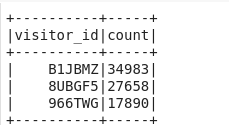


In [ ]:
## BEGIN CODE
click_data.groupBy('visitor_id').count().show(3)
## END CODE

+----------+-----+
|visitor_id|count|
+----------+-----+
|    1W7XI2|19218|
|    AALK16|29364|
|    DJH37U| 4156|
+----------+-----+
only showing top 3 rows



In [ ]:
## Let us look at the variable types
click_data.dtypes
##  As you can see everything is a string but we would like to understand click_time as a date

[('visitor_id', 'string'),
 ('click_time', 'string'),
 ('product', 'string'),
 ('event_type', 'string')]

In [ ]:
#
# Let us now convert the click_date into a date format 
# A lambda function also known as anonymous function does the operation to the right of ":" on each input

func =  udf (lambda x: datetime.strptime(x, '%Y/%m/%d %H:%M:%S'),TimestampType())
click_data=click_data.withColumn('click_time', func(col('click_time')))
click_data.dtypes


[('visitor_id', 'string'),
 ('click_time', 'timestamp'),
 ('product', 'string'),
 ('event_type', 'string')]

In [ ]:
click_data.show(5)

+----------+-------------------+--------+-----------+
|visitor_id|         click_time| product| event_type|
+----------+-------------------+--------+-----------+
|    BDOD6B|2019-10-18 06:09:28|10135281|      click|
|    BDOD6B|2019-10-18 06:09:31|PN956018|      click|
|    BDOD6B|2019-10-18 06:09:33|B0411252|      click|
|    BDOD6B|2019-10-18 06:09:35|PN956018|      click|
|    BDOD6B|2019-10-18 06:09:43|10182874|Add_to_Cart|
+----------+-------------------+--------+-----------+
only showing top 5 rows



In [ ]:
## Now let us add only the date as an extra column

func1 =  udf (lambda x: datetime.date(x), DateType())
click_data=click_data.withColumn('click_date', func1(col('click_time')))
click_data.dtypes

[('visitor_id', 'string'),
 ('click_time', 'timestamp'),
 ('product', 'string'),
 ('event_type', 'string'),
 ('click_date', 'date')]

In [ ]:
click_data.show()

+----------+-------------------+--------+-----------+----------+
|visitor_id|         click_time| product| event_type|click_date|
+----------+-------------------+--------+-----------+----------+
|    BDOD6B|2019-10-18 06:09:28|10135281|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:09:31|PN956018|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:09:33|B0411252|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:09:35|PN956018|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:09:43|10182874|Add_to_Cart|2019-10-18|
|    BDOD6B|2019-10-18 06:09:45|PN694444|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:09:48|PN539251|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:09:55|PN916786|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:10:00|PN939021|Add_to_Cart|2019-10-18|
|    BDOD6B|2019-10-18 06:10:05|PN589720|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:10:13| 1122445|      click|2019-10-18|
|    BDOD6B|2019-10-18 06:10:22|10191837|      click|2019-10-18|
|    BDOD6B|2019-10-18 06

In [ ]:
# Now let us count the number of clicks per day
#  This will be similar to what you have written earlier for counting per visitor
## BEGIN CODE
click_data.groupBy('click_date').count().show(5)
## END CODE

+----------+-----+
|click_date|count|
+----------+-----+
|2019-11-01|29970|
|2019-11-18|29946|
|2019-11-21|33659|
|2019-10-24|26635|
|2019-12-28|17455|
+----------+-----+
only showing top 5 rows



In [ ]:
day_wise_counts=click_data.groupBy('click_date').count()

In [ ]:
day_wise_counts_pd=day_wise_counts.toPandas()

In [ ]:
day_wise_counts_pd.sort_values(by='click_date',inplace=True)

In [ ]:
# This process fills up missing dates with zero value. This is unlikely to happen on a real production dataset however.
# Please understand this step since you would need to use it a bit later again on your own.

day_wise_counts_pd = day_wise_counts_pd.set_index('click_date').asfreq('d', fill_value=0).reset_index()
day_wise_counts_pd.head()

,click_date,count
0,2019-10-06,2026
1,2019-10-07,3447
2,2019-10-08,4600
3,2019-10-09,6784
4,2019-10-10,8055


In [ ]:
day_wise_counts_pd.shape

(89, 2)

In [ ]:
import pandas as pd
import os
import numpy as np
# import calmap
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap 

In [ ]:
!pip install calmap

In [ ]:
import calmap

In [ ]:
dates_of_list=list(set(list(day_wise_counts_pd['click_date'])))


In [ ]:
dates_of_list.sort()

In [ ]:
num_days=dates_of_list[-1]-dates_of_list[0]
num_days=num_days.days
print (num_days)

88


In [ ]:
dates_of_list[0]

Timestamp('2019-10-06 00:00:00')

In [ ]:
dates_of_list[-1]

Timestamp('2020-01-02 00:00:00')

In [ ]:
All_Days = pd.date_range('10/6/2019', periods=num_days+1, freq= 'D')

In [ ]:
counts=np.array(day_wise_counts_pd['count'])

In [ ]:
Events = pd.Series(counts,index= All_Days)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f61f443d898>,
       dtype=object))

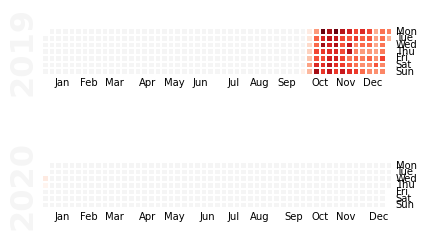

In [ ]:
calmap.calendarplot(Events)

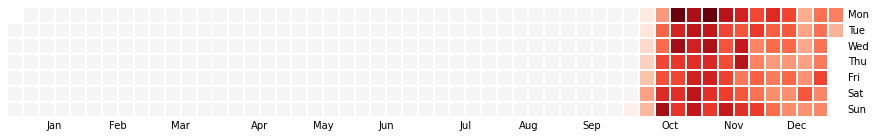

In [ ]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
calmap.yearplot(Events,year=2019, ax=ax)

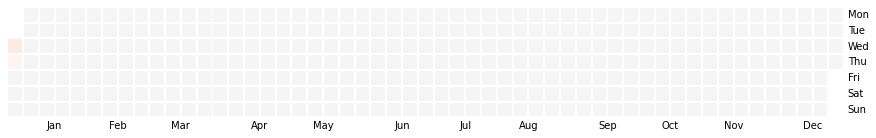

In [ ]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
calmap.yearplot(Events, year = 2020, ax=ax)

Assignment - Plot the calendar plots for 

Wishlist
Cart
Purchase 

events in a similar way

**Note**:-  You need to filter for the individual events. This may give you lots of missing dates - which you fill up as above.

To filter on a value refer to https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/ and search by 

"If I want to filter the rows in train which has Purchase more than 15000?"


In [ ]:
curr_date=datetime.datetime(2020, 1, 1)
print (curr_date)

2020-01-01 00:00:00


In [ ]:
click_data.dtypes

[('visitor_id', 'string'),
 ('click_time', 'timestamp'),
 ('product', 'string'),
 ('event_type', 'string'),
 ('click_date', 'date')]

In [ ]:
click_data.createOrReplaceTempView("click_data_df")


In [ ]:
click_data.groupBy('event_type').count().show()

+---------------+-------+
|     event_type|  count|
+---------------+-------+
|       Purchase|     53|
|Add_to_Wishlist|  89754|
|    Add_to_Cart|    334|
|          click|1891308|
+---------------+-------+



In [ ]:
daily_counts=click_data.groupBy(['visitor_id','event_type','click_date']).count()

In [ ]:
daily_counts.show()

+----------+---------------+----------+-----+
|visitor_id|     event_type|click_date|count|
+----------+---------------+----------+-----+
|    KL08L7|          click|2019-10-26| 1503|
|    TL2D3A|          click|2019-10-18|  125|
|    RBZYCY|          click|2019-12-02|   79|
|    P6SIQ6|          click|2019-10-11|  859|
|    P6SIQ6|          click|2019-10-13|  843|
|    X87T8I|          click|2019-10-19|  457|
|    ZKFCNA|Add_to_Wishlist|2019-12-29|   17|
|    M3JD5E|Add_to_Wishlist|2019-10-15|   39|
|    KC31KQ|Add_to_Wishlist|2019-11-12|   20|
|    TS0105|          click|2019-10-19|  508|
|    L4GAGJ|          click|2019-11-01|  772|
|    7CWYJB|          click|2019-11-07| 1246|
|    GZSDIV|          click|2019-10-21|  318|
|    4ANGCH|    Add_to_Cart|2019-10-06|    4|
|    HUIVJV|Add_to_Wishlist|2019-10-14|   10|
|    HUIVJV|Add_to_Wishlist|2019-11-18|   83|
|    BQQUA2|          click|2019-10-26| 1299|
|    ZK974B|Add_to_Wishlist|2019-11-17|   58|
|    6WC8OZ|Add_to_Wishlist|2019-1

In [ ]:
daily_counts.createOrReplaceTempView("daily_counts_df")


In [ ]:
features_df=spark.sql(\
          "select * from \
(select visitor_id\
,sum(case when click_date>=TO_DATE('12/31/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) all_clicks_1_day\
,sum(case when click_date>=TO_DATE('12/29/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) all_clicks_3_day\
,sum(case when click_date>=TO_DATE('12/25/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) all_clicks_7_day\
,sum(case when click_date>=TO_DATE('12/04/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) all_clicks_28_day\
,sum(case when event_type='Add_to_Cart' and click_date>=TO_DATE('12/31/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) cart_1_day\
,sum(case when event_type='Add_to_Cart' and click_date>=TO_DATE('12/29/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) cart_3_day\
,sum(case when event_type='Add_to_Cart' and click_date>=TO_DATE('12/25/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) cart_7_Days\
,sum(case when event_type='Add_to_Cart' and click_date>=TO_DATE('12/04/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) cart_28_Days\
,sum(case when event_type='Add_to_Wishlist' and click_date>=TO_DATE('12/31/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) wl_1_day\
,sum(case when event_type='Add_to_Wishlist' and click_date>=TO_DATE('12/29/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) wl_3_day\
,sum(case when event_type='Add_to_Wishlist' and click_date>=TO_DATE('12/25/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) wl_7_Days\
,sum(case when event_type='Add_to_Wishlist' and click_date>=TO_DATE('12/04/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) wl_28_Days\
,sum(case when event_type='Purchase' and click_date>=TO_DATE('12/31/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) buy_1_Days\
,sum(case when event_type='Purchase' and click_date>=TO_DATE('12/29/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) buy_3_Days\
,sum(case when event_type='Purchase' and click_date>=TO_DATE('12/25/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) buy_7_Days\
,sum(case when event_type='Purchase' and click_date>=TO_DATE('12/04/2019','mm/dd/yyyy')  then 1 else 0 end) over (partition by visitor_id order by click_date desc) buy_28_Days\
,row_number() over (partition by visitor_id order by click_date desc) rn\
 from click_data_df\
 ) \
 where rn=1"\
 )

In [ ]:
features_df.filter(features_df["all_clicks_7_day"]>0).show()

+----------+----------------+----------------+----------------+-----------------+----------+----------+-----------+------------+--------+--------+---------+----------+----------+----------+----------+-----------+---+
|visitor_id|all_clicks_1_day|all_clicks_3_day|all_clicks_7_day|all_clicks_28_day|cart_1_day|cart_3_day|cart_7_Days|cart_28_Days|wl_1_day|wl_3_day|wl_7_Days|wl_28_Days|buy_1_Days|buy_3_Days|buy_7_Days|buy_28_Days| rn|
+----------+----------------+----------------+----------------+-----------------+----------+----------+-----------+------------+--------+--------+---------+----------+----------+----------+----------+-----------+---+
|    1W7XI2|             764|             764|             764|              764|         0|         0|          0|           0|      32|      32|       32|        32|         0|         0|         0|          0|  1|
|    AALK16|            3491|            3491|            3491|             3491|         0|         0|          0|           0|    

In [ ]:
spark.sql("\
select visitor_id \
,click_date\
,lag(click_date) over (partition by visitor_id order by click_date desc) lag_click_date \
from daily_counts_df \
where visitor_id='1W7XI2' \
order by click_date desc \
"\
).show()

+----------+----------+--------------+
|visitor_id|click_date|lag_click_date|
+----------+----------+--------------+
|    1W7XI2|2019-12-20|          null|
|    1W7XI2|2019-12-20|    2019-12-20|
|    1W7XI2|2019-12-08|    2019-12-20|
|    1W7XI2|2019-12-08|    2019-12-08|
|    1W7XI2|2019-12-06|    2019-12-08|
|    1W7XI2|2019-12-06|    2019-12-06|
|    1W7XI2|2019-12-05|    2019-12-06|
|    1W7XI2|2019-12-05|    2019-12-05|
|    1W7XI2|2019-12-02|    2019-12-05|
|    1W7XI2|2019-12-02|    2019-12-02|
|    1W7XI2|2019-12-02|    2019-12-02|
|    1W7XI2|2019-12-01|    2019-12-02|
|    1W7XI2|2019-12-01|    2019-12-01|
|    1W7XI2|2019-11-19|    2019-11-19|
|    1W7XI2|2019-11-19|    2019-12-01|
|    1W7XI2|2019-11-18|    2019-11-19|
|    1W7XI2|2019-11-18|    2019-11-18|
|    1W7XI2|2019-11-17|    2019-11-18|
|    1W7XI2|2019-11-17|    2019-11-17|
|    1W7XI2|2019-11-16|    2019-11-17|
+----------+----------+--------------+
only showing top 20 rows

